In [55]:
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# For image processing
from PIL import Image
import torchvision.models as models
import torchvision.transforms as transforms
import torch


In [56]:
# Load the CSV file
data = pd.read_csv('../data/instagram_data.csv')

# Check for missing values and handle them
data.dropna(inplace=True)


In [57]:
# Define bins for likes
# Calculate the 33rd and 66th percentiles
p33 = np.percentile(data['likes'], 33)
p66 = np.percentile(data['likes'], 66)

# Define the bins based on percentiles
bins = [0, p33, p66, np.inf]
labels = ['Low', 'Medium', 'High']

# Categorize the 'likes' column using these percentiles
data['likes_class'] = pd.cut(data['likes'], bins=bins, labels=labels)

# Print the chosen bin ranges
print(f"Low: 0 to {p33}")
print(f"Medium: {p33} to {p66}")
print(f"High: {p66} and above")


# Encode labels to numeric values
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['likes_class_encoded'] = le.fit_transform(data['likes_class'])


Low: 0 to 68295.68000000001
Medium: 68295.68000000001 to 189775.28
High: 189775.28 and above


In [58]:
import torch
from torchvision import models, transforms
from PIL import Image
import numpy as np
import pandas as pd

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the pre-trained ResNet50 model and remove the last classification layer
resnet = models.resnet50(pretrained=True)
resnet = torch.nn.Sequential(*list(resnet.children())[:-1])  # Remove the classification layer
resnet.to(device)
resnet.eval()

# Define the transformations to apply to each image
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),          # Convert images to tensors
    transforms.Normalize(           # Normalize images with mean and std of ImageNet
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Function to extract features using ResNet50
def extract_features(image_path):
    try:
        image = Image.open(image_path).convert('RGB')  # Open and convert the image to RGB
        image = transform(image)  # Apply the image transformations
        image = image.unsqueeze(0).to(device)
        
        # Extract features
        with torch.no_grad():
            features = resnet(image)
        
        # Flatten the feature map and convert it to a numpy array
        features = features.cpu().numpy().flatten()  # Move features back to CPU and flatten
        return features
    
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

# Initialize a list to store features
image_features = []

# Iterate over each image path in the dataset (assuming 'data' DataFrame has an 'image_path' column)
for idx, row in data.iterrows():
    img_path = row['image_path']
    features = extract_features(img_path)
    
    # Append the features or a zero vector if feature extraction failed
    if features is not None:
        image_features.append(features)
    else:
        image_features.append(np.zeros(2048))

# Convert the list of features into a DataFrame
image_features_df = pd.DataFrame(image_features)

# Check the shape of the resulting DataFrame
print(f"Extracted features for {len(image_features)} images with {image_features_df.shape[1]} features each.")


d:\VSCODE\Python\fun_projects\FPkernal\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\VSCODE\Python\fun_projects\FPkernal\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Extracted features for 3785 images with 2048 features each.


In [59]:
# Generate new column names with a prefix
feature_columns = [f'feat_{i}' for i in range(image_features_df.shape[1])]

# Assign new column names to image_features_df
image_features_df.columns = feature_columns


In [60]:
# Reset indices to ensure alignment
data.reset_index(drop=True, inplace=True)
image_features_df.reset_index(drop=True, inplace=True)

# Combine data and image features
combined_data = pd.concat([data, image_features_df], axis=1)


In [61]:
exclude_columns = ['likes', 't', 'image_path', 'likes_class', 'likes_class_encoded']
feature_columns = [col for col in combined_data.columns if col not in exclude_columns]


In [62]:
X = combined_data[feature_columns]
y = combined_data['likes_class_encoded']


In [63]:
# Convert all column names to strings
X.columns = X.columns.map(str)


In [64]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)


In [65]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [66]:
y_pred = model.predict(X_test)


              precision    recall  f1-score   support

         Low       0.62      0.70      0.66       257
      Medium       0.61      0.65      0.63       250
        High       0.48      0.39      0.43       250

    accuracy                           0.58       757
   macro avg       0.57      0.58      0.57       757
weighted avg       0.57      0.58      0.57       757



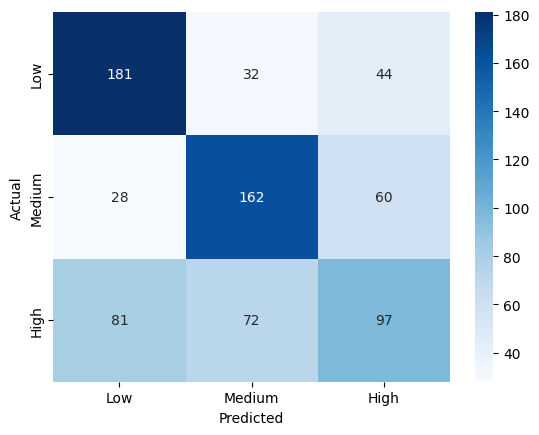

In [67]:
print(classification_report(y_test, y_pred, target_names=labels))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
